In [11]:
import random
import torch
import matplotlib.pyplot as plt
import supervision as sv
import numpy as np
import cv2
import re


from pathlib import Path
from ultralytics import YOLO
from collections import defaultdict


In [2]:
MODEL_PATH = Path("runs/detect/train4/weights/best.pt")
VAL_IMAGES_DIR = Path("data/tracking/YOLO/images/val")
VIDEO_OUT_DIR = Path("videos")
VIDEO_OUT_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = YOLO(str(MODEL_PATH))
model.to(device)
print("Loaded model from:", MODEL_PATH)

names = model.names  
print("Classes:", names)

Using device: cuda
Loaded model from: runs/detect/train4/weights/best.pt
Classes: {0: 'player', 1: 'referee', 2: 'ball', 3: 'goalkeeper'}


Inference on: SNMOT-168_000681.jpg


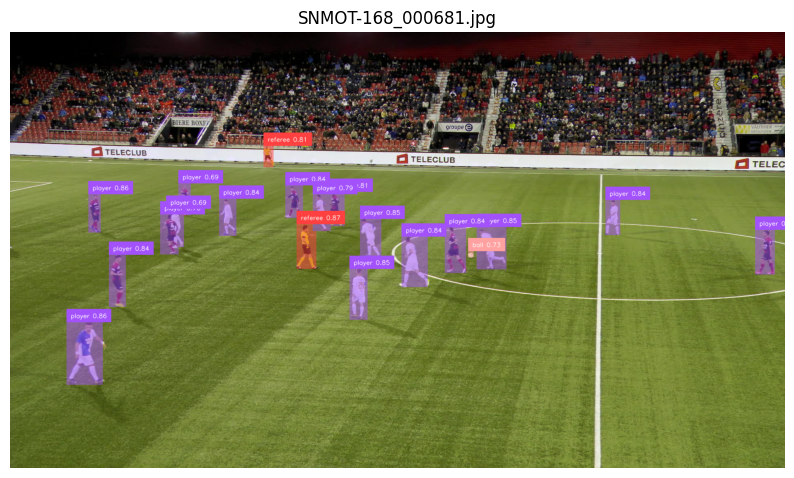

In [10]:
img_path = random.choice(list(Path(VAL_IMAGES_DIR).glob("*.jpg")))
print("Inference on:", img_path.name)

result = model(str(img_path), imgsz=640, device=device, verbose=False)[0]

detections = sv.Detections.from_ultralytics(result)

labels = [
    f"{names[int(cls_id)]} {conf:.2f}"
    for cls_id, conf in zip(detections.class_id, detections.confidence)
]

image_bgr = cv2.imread(str(img_path))

color_annotator = sv.ColorAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_bgr = color_annotator.annotate(
    scene=image_bgr.copy(),
    detections=detections
)
annotated_bgr = label_annotator.annotate(
    scene=annotated_bgr,
    detections=detections,
    labels=labels
)

annotated_rgb = cv2.cvtColor(annotated_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(annotated_rgb)
plt.axis("off")
plt.title(img_path.name)
plt.show()

In [12]:
pat = re.compile(r"SNMOT-(\d+)_(\d+)\.jpg$")
clip_to_frames = defaultdict(int)

for p in Path(VAL_IMAGES_DIR).glob("SNMOT-*_*.jpg"):
    m = pat.match(p.name)
    if m:
        clip_id = int(m.group(1))
        clip_to_frames[clip_id] += 1

clip_ids = sorted(clip_to_frames.keys())
print(f"Found {len(clip_ids)} clips in {VAL_IMAGES_DIR}")
print("All clip IDs:")
print(clip_ids)

if not clip_ids:
    raise FileNotFoundError(f"No SNMOT-{{clip}}_{{frame}}.jpg files found in {VAL_IMAGES_DIR}")

CLIP_ID = random.choice(clip_ids)
print(f"Randomly selected existing CLIP_ID = {CLIP_ID}  (frames: {clip_to_frames[CLIP_ID]})")

Found 12 clips in data/tracking/YOLO/images/val
All clip IDs:
[159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170]
Randomly selected existing CLIP_ID = 170  (frames: 750)


In [ ]:

frame_paths = []
for p in Path(VAL_IMAGES_DIR).glob(f"SNMOT-{CLIP_ID}_*.jpg"):
    m = pat.match(p.name)
    if m:
        frame_no = int(m.group(2))
        frame_paths.append((frame_no, p))

frame_paths.sort(key=lambda x: x[0])
frame_numbers = [fn for fn, _ in frame_paths]
frame_paths = [p for _, p in frame_paths]

print(f"Clip {CLIP_ID}: {len(frame_paths)} frames")



Clip 170: 750 frames
First frame resolution: 1920x1080 (expected 1920x1080)


In [ ]:
IMG_SIZE = 960          
CONF_TH = 0.25
STORE_IN_MEMORY = False # if True, also keeps crops as numpy arrays in `player_crops`

# Use model's class names
names = model.names if hasattr(model, "names") else {}
player_class_ids = {cid for cid, name in names.items() if str(name).lower() == "player"}


# Output dirs
CROPS_DIR = Path("data/tracking/crops") / f"clip_{CLIP_ID}"
CROPS_DIR.mkdir(parents=True, exist_ok=True)

# Optional progress bar
try:
    from tqdm.auto import tqdm
    it = tqdm(list(zip(frame_numbers, frame_paths)), total=len(frame_paths))
except Exception:
    it = zip(frame_numbers, frame_paths)

crops_meta = []
player_crops = []

for frame_no, img_path in it:
    image_bgr = cv2.imread(str(img_path))
    if image_bgr is None:
        continue

    # YOLO inference
    r0 = model(str(img_path), imgsz=IMG_SIZE, device=device if "device" in globals() else None, verbose=False)[0]
    det = sv.Detections.from_ultralytics(r0)

    if det.class_id is None or det.confidence is None or len(det) == 0:
        continue

    keep = np.isin(det.class_id, list(player_class_ids)) & (det.confidence >= CONF_TH)
    det = det[keep]
    if len(det) == 0:
        continue

    h, w = image_bgr.shape[:2]  # should be 1080x1920

    for j, (xyxy, conf, cls_id) in enumerate(zip(det.xyxy, det.confidence, det.class_id)):
        x1, y1, x2, y2 = map(int, xyxy)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w - 1, x2), min(h - 1, y2)
        if x2 <= x1 or y2 <= y1:
            continue

        crop_bgr = image_bgr[y1:y2, x1:x2]
        crop_path = CROPS_DIR / f"{img_path.stem}_det{j:03d}_conf{conf:.3f}.jpg"
        cv2.imwrite(str(crop_path), crop_bgr)

        crops_meta.append({
            "clip_id": int(CLIP_ID),
            "frame_number": int(frame_no),
            "frame_path": str(img_path),
            "det_index": int(j),
            "class_id": int(cls_id),
            "class_name": names.get(int(cls_id), str(cls_id)),
            "confidence": float(conf),
            "xyxy": [int(x1), int(y1), int(x2), int(y2)],
            "crop_path": str(crop_path),
        })

        if STORE_IN_MEMORY:
            player_crops.append(crop_bgr)

# Save metadata JSON
meta_path = CROPS_DIR / "crops_meta.json"
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(crops_meta, f, indent=2)

print(f"Saved {len(crops_meta)} player crops into: {CROPS_DIR}")
print(f"Metadata saved to: {meta_path}")
print("Example meta:", crops_meta[0] if crops_meta else None)

 43%|████▎     | 322/750 [00:15<00:20, 20.43it/s]